![Facial Recognition](facialrecognition.jpg)

You are a member of an elite group of data scientists, specialising in advanced facial recognition technology, this firm is dedicated to identifying and safeguarding prominent individuals from various spheres—ranging from entertainment and sports to politics and philanthropy. The team's mission is to deploy AI-driven solutions that can accurately distinguish between images of notable personalities and the general populace, enhancing the personal security of such high-profile individuals. You're to focus on Arnold Schwarzenegger, a figure whose accomplishments span from bodybuilding champion to Hollywood icon, and from philanthropist to the Governor of California. 

### **The Data**
The `data/lfw_arnie_nonarnie.csv` dataset contains processed facial image data derived from the "Labeled Faces in the Wild" (LFW) dataset, focusing specifically on images of Arnold Schwarzenegger and other individuals not identified as him. This dataset has been prepared to aid in the development and evaluation of facial recognition models. There are 40 images of Arnold Schwarzenegger and 150 of other people.

| Column Name | Description |
|-------------|-------------|
| PC1, PC2, ... PCN | Principal components from PCA, capturing key image features. |
| Label | Binary indicator: `1` for Arnold Schwarzenegger, `0` for others. |

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file 
df = pd.read_csv("data/lfw_arnie_nonarnie.csv")

# Seperate the predictor and class label
X = df.drop('Label', axis=1)
y = df['Label'] 

# Split the data into training and testing sets using stratify to balance the class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [2]:
# Start coding here
#initializing three classification models
models = {"logreg":LogisticRegression(),
         "Dtree":DecisionTreeClassifier(),
         "knn":KNeighborsClassifier()}

In [3]:
# Create a dict to define the parameters for the Pipeline
params = {
    'logreg': {'logreg__C': [0.01, 0.1, 1, 10]},
    'Dtree': {'Dtree__max_depth': [2, 5, 10], 'Dtree__min_samples_split': [2, 5, 10, 20], 'Dtree__random_state': [42]},
    'knn': {'knn__n_neighbors': range(1, 10)}
}

In [4]:
#set up Kfold, it is used to ensure that our model generalizes well on unseen data 
kf = KFold(n_splits=3,shuffle=True, random_state=42)

In [5]:
#prepare to collect the Grid search CV result
#GridSearchCV helps find the best parameter combination for each model
pipe_accuracies = {}
pipe_param = {}
pipelines = {}

In [6]:
# Create separate pipelines for each model, loop through the models and perform GridSearchCV
# Grid Search helps find the best parameter combination for each model
# Pipelines integrate preprocessing (e.g., scaling) with the model for cleaner code and to prevent data leakage
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        (name, model)
    ])
    # Create the GridSearchCV object
    grid_search = GridSearchCV(pipeline, params[name], cv=kf, scoring="accuracy")
    
    # Perform grid search and fit the model and store the results
    grid_search.fit(X_train, y_train)
    pipe_accuracies[name] = grid_search.best_score_
    pipe_param[name] = grid_search.best_params_
    pipelines[name] = grid_search

In [7]:
#Select the best model based on the best cv score
best_model_name = max(pipe_accuracies)
best_model_info = pipe_param[best_model_name]
best_model_cv_score = max(pipe_accuracies.values())

worst_model_name = min(pipe_accuracies)
worst_model_info = pipe_param[worst_model_name]
worst_model_cv_score = min(pipe_accuracies.values())

#print the best model name , parameters and CV score
print(f"The best Model: {best_model_name}")
print(f"The best Model Parameters: {best_model_info}")
print(f"The Best Model CV Score:{best_model_cv_score}")

print("="*50)

#print the worst model name , parameters and CV score
print(f"The worst Model: {worst_model_name}")
print(f"The worst Model Parameters: {worst_model_info}")
print(f"The worst Model CV Score:{worst_model_cv_score}")

The best Model: logreg
The best Model Parameters: {'logreg__C': 10}
The Best Model CV Score:0.8219607843137254
The worst Model: Dtree
The worst Model Parameters: {'Dtree__max_depth': 2, 'Dtree__min_samples_split': 2, 'Dtree__random_state': 42}
The worst Model CV Score:0.6967320261437909


In [8]:
#compute and print key performance metrics
y_pred = pipelines[best_model_name].predict(X_test)
y_pred_dtree = pipelines[worst_model_name].predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy:0.7895
Precision: 0.5000
Recall: 0.1250
F1 Score: 0.2000


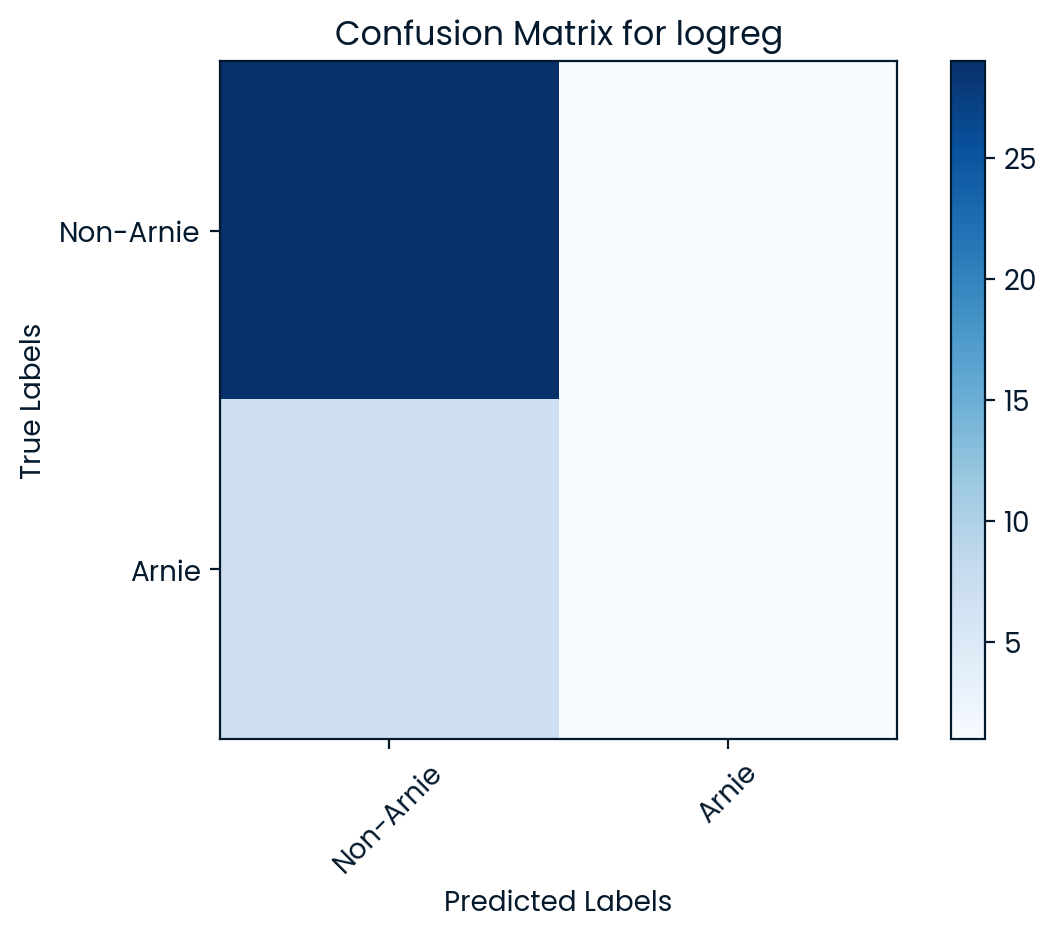

In [9]:
#visualize the confusion matrix using matplotlib to help understand how well the model is predicting each class
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.colorbar()
tick_marks = range(len(set(y_test)))
plt.xticks(tick_marks, ['Non-Arnie', 'Arnie'], rotation=45)
plt.yticks(tick_marks, ['Non-Arnie', 'Arnie'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


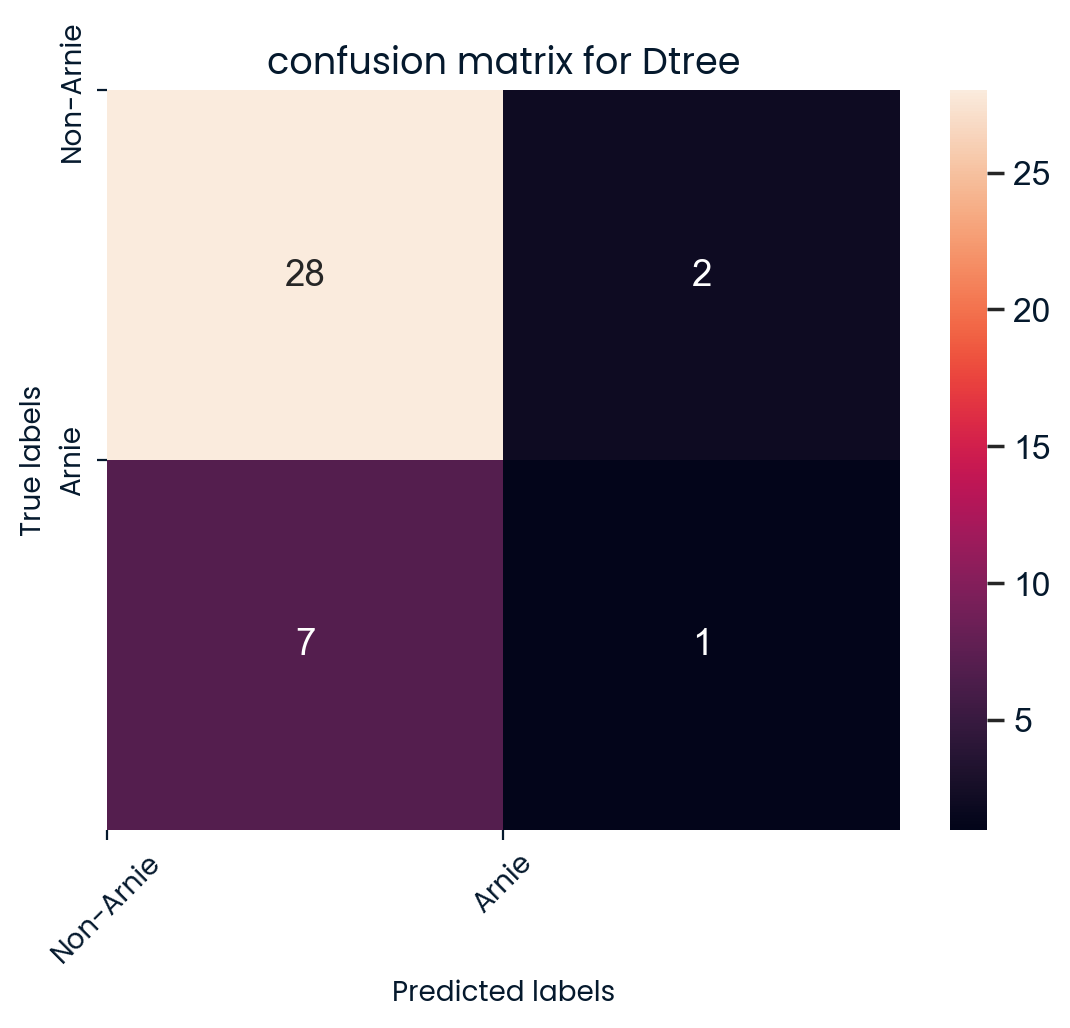

In [10]:
conf_matrix_worst = confusion_matrix(y_test, y_pred_dtree)
fig, ax = plt.subplots()
sns.set(font_scale=1.1)

ax = sns.heatmap(conf_matrix_worst, annot=True, fmt='d')
ax.set_title(f"confusion matrix for {worst_model_name}")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
tick_marks = range(len(set(y_test)))
ax.set_xticks(tick_marks, ['Non-Arnie', 'Arnie'], rotation=45)
ax.set_yticks(tick_marks, ['Non-Arnie', 'Arnie'])
plt.show()